# Multi-Variate EOF and candidates selection 
On va d'abbord récupérer les composants principaux des EOFs individuelles des différentes variables. 
Puis on concatenate les matrices de PCs d'EOF individuelle tronquée sur une même dimension : 

- Dimension 1 : les différents membres de l'ensemble (n = 102) 

- Dimension 2 : les PCs d'EOFs individuelles tronquées pour les différentes variables (n = n_tronquée * n_variables). Ici n_tronquée = 5 modes et n_variables = 5 variables.

# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
import scipy 
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# Settings

### Variables

In [2]:
variables = ['tas', 'pr', 'SW', 'LW', 'psl']

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [5]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

# Get data : obs

On récupère directement les data projetées sur la base EOF du PPE, de la variable correspondante. (U_obs)

### Temperature : BEST data

In [6]:
var = 'tas'
U_obs = {}
U_obs[var] = np.load(path_files+'npy/CNRMppe_decomposition_U_obs_'+var+'.npy')
U_obs[var]

array([-35.30081 , -39.041958,  62.09356 ,  44.23777 , -57.485878],
      dtype=float32)

### Precipitation : GPCP

In [7]:
var = 'pr'
U_obs[var] = np.load(path_files+'npy/CNRMppe_decomposition_U_obs_'+var+'.npy')
U_obs[var]

array([118.08318081, -75.96825392, -10.60677721,  47.43860722,
       -77.10519667])

### SW : CERES data 

In [8]:
var = 'SW'
U_obs[var] = np.load(path_files+'npy/CNRMppe_decomposition_U_obs_'+var+'.npy')
U_obs[var]

array([  923.1411 , -1032.1937 ,  -561.6581 ,   336.58038,    87.92828],
      dtype=float32)

### LW : CERES data

In [9]:
var = 'LW'
U_obs[var] = np.load(path_files+'npy/CNRMppe_decomposition_U_obs_'+var+'.npy')
U_obs[var]

array([  27.709879,  388.57288 ,  821.90375 ,  -89.317825, -232.15962 ],
      dtype=float32)

### Pressure : NCEP

In [10]:
var = 'psl'
U_obs[var] = np.load(path_files+'npy/CNRMppe_decomposition_U_obs_'+var+'.npy')
U_obs[var]

array([ 17916.693,  10520.148,  22854.988, -17135.393,  -9038.122],
      dtype=float32)

# Multi-variate EOF 

On récupère les PC des 5 premiers modes chaque EOF (correspondant à chacune des 5 variables), on les normalise par la moyenne d'ensemble des pc, puis on fait l'EOF multi-variate. 

In [11]:
pc_PPE = {}

for var in variables : 
    pc = []
    for j in range(1,6, 1) :
        tmp = np.load(path_files+'npy/CNRMppe_decomposition_EOF'+str(j)+'pc_'+str(var)+'.npy')
        pc.append(tmp)
    pc_PPE[str(var)] = pc

In [12]:
# On normalize également les PCs en enlevant la moyenne d'ensemble et divisant par l'écart-type : 
df_pc_PPE_norm = pd.DataFrame(pc_PPE['tas'][0], columns = ['tas - EOF 1'])
mean = {}
std = {}
for var in variables : 
    for j in range(1,6, 1) :
        tmp = pc_PPE[var][j-1]
        tmp_mean = pc_PPE[var][j-1].mean()
        tmp_std = pc_PPE[var][j-1].std()
        
        df_pc_PPE_norm[var+' - EOF '+str(j)] = (tmp - tmp_mean)/tmp_std
        mean[var+' - EOF '+str(j)] = tmp_mean
        std[var+' - EOF '+str(j)] = tmp_std
df_pc_PPE_norm

,tas - EOF 1,tas - EOF 2,tas - EOF 3,tas - EOF 4,tas - EOF 5,pr - EOF 1,pr - EOF 2,pr - EOF 3,pr - EOF 4,pr - EOF 5,...,LW - EOF 1,LW - EOF 2,LW - EOF 3,LW - EOF 4,LW - EOF 5,psl - EOF 1,psl - EOF 2,psl - EOF 3,psl - EOF 4,psl - EOF 5
0,-0.744489,-1.673261,0.853752,0.042470,-1.548252,-0.636492,1.232000,0.718669,-0.586214,0.898512,...,-0.740630,0.149068,-0.210366,-0.392028,2.001104,-0.684246,-1.937335,0.125499,1.939961,1.921937
1,0.307994,0.724050,-0.675794,-0.422953,1.644540,-0.827055,-0.398111,0.512189,-0.352457,-0.154650,...,0.301492,-0.345761,-1.048826,0.371093,-0.330773,0.072250,0.977608,-0.909045,0.671314,-0.360227
2,1.687605,-0.849755,0.109793,0.104752,-0.670095,-0.328727,-0.188585,0.640106,-0.573277,1.764534,...,1.811387,0.572975,-0.217129,0.530132,0.623857,-0.107168,0.308263,-0.507369,0.474761,-0.173217
3,0.529297,-1.642946,-0.151469,-0.657469,1.692734,-1.831913,0.058098,0.743906,-0.234946,-0.333954,...,0.518465,-0.880733,-1.821710,0.067228,-0.740356,-0.997948,1.333931,-0.777306,0.555326,-0.196770
4,0.688822,0.156021,0.255692,-0.848135,-1.852867,1.006320,0.079897,1.966904,1.738780,1.958663,...,0.652091,-0.164390,0.214764,1.577974,0.698172,-0.658479,-0.829874,1.739421,0.762109,-0.691717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.644371,-0.737653,-2.033379,-0.570061,0.835376,-1.372081,-0.487129,0.044131,0.002247,0.483887,...,-0.298226,0.179859,-1.061704,0.351855,-0.889566,-0.138683,1.674873,0.497884,-0.481120,-1.554459
98,-1.469338,0.986660,-2.543679,1.143452,0.296719,0.951342,-1.034900,-0.808521,-0.805487,-0.030553,...,-0.434170,-2.133588,0.798420,1.574823,-1.617914,1.088275,0.673505,1.526290,0.082438,-0.765884
99,-0.435799,1.090412,-1.237641,1.773306,1.054716,0.386599,-0.216890,0.014379,-0.619977,-0.253288,...,0.102120,-0.798628,0.347578,0.315628,-0.183916,1.760727,1.368530,0.388749,1.007138,0.344169
100,1.373877,-0.031661,-1.635394,0.188671,0.496991,0.504464,-0.264270,1.252899,-0.424700,-0.240763,...,0.724235,-0.368940,-0.054803,0.724481,0.174744,0.924846,1.336779,-0.370561,0.398990,-0.339809


In [13]:
xr_pc_PPE_norm = xr.DataArray(df_pc_PPE_norm.values, dims = ['time', 'var - EOF nb'])
xr_pc_PPE_norm

<xarray.DataArray (time: 102, var - EOF nb: 25)>
array([[-0.74448884, -1.67326057,  0.85375196, ...,  0.12549919,
         1.93996143,  1.92193687],
       [ 0.30799401,  0.72405022, -0.67579436, ..., -0.90904528,
         0.67131424, -0.36022729],
       [ 1.68760538, -0.84975493,  0.10979337, ..., -0.50736922,
         0.47476071, -0.17321669],
       ...,
       [-0.43579939,  1.09041238, -1.23764086, ...,  0.38874912,
         1.00713849,  0.34416884],
       [ 1.37387657, -0.03166063, -1.63539433, ..., -0.3705613 ,
         0.39899036, -0.33980888],
       [ 0.97398943,  1.05172396, -0.25128341, ..., -0.1854627 ,
        -0.88589621, -2.1546607 ]])
Dimensions without coordinates: time, var - EOF nb

In [14]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(xr_pc_PPE_norm, center=False)

In [15]:
pc_multi = solver.pcs(npcs=100, pcscaling=0)
varFrac = solver.varianceFraction(neigs=100)

## Projection des Observations

In [16]:
U_obs_list = []
for var in variables : 
    for j in range(1,6,1) : 
        tmp = U_obs[var][j-1]
        tmp_mean = mean[var+' - EOF '+str(j)]
        tmp_std = std[var+' - EOF '+str(j)]
        tmp_result = (tmp - tmp_mean) / tmp_std
        U_obs_list.append(tmp_result)
xr_U_obs = xr.DataArray(U_obs_list, dims=['var - EOF nb'])
xr_U_obs

<xarray.DataArray (var - EOF nb: 25)>
array([-0.20005496, -0.448728  ,  1.31102204,  1.35844529, -2.28400946,
        1.68211675, -1.39559081, -0.27434421,  1.48503639, -2.76564599,
        0.58721107, -1.51369441, -1.03627574,  1.06817269,  0.33120763,
        0.02778933,  0.97488576,  2.51172781, -0.40681612, -1.22054017,
        0.50602096,  1.04733646,  2.7644105 , -3.30343604, -2.02886581])
Dimensions without coordinates: var - EOF nb

In [17]:
U_obs_multi = solver.projectField(xr_U_obs, neofs=5, weighted=False, eofscaling=0)
U_obs_multi

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([ 3.86302014, -0.10712115, -1.68595499, -0.92992416, -1.32807647])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  None_pseudo_pcs

# Emulation

### Evaluation du skill de l'émulateur pour l'EOF multi-variables

In [22]:
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = pc_multi[:,0]

X_train = X[0:80]
y_train = y[0:80]
X_test = X[80:]
y_test = y[80:]
#LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

# Let's use the model equation : 
X_df = pd.DataFrame(data=X)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
R = regr.intercept_
Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

N=len(y_test)
tmp = [0]*N
y_pred = [0]*N
i=0
Ycpt=0
while i<N:
        
    tmp[i] = Coeffs.values*X_test[i]
    y_pred[i] = tmp[i].sum()+R
    i+=1

In [19]:
df_train = pd.DataFrame(y_train, columns = ['y_train'])
df_train['pred'] = y_pred
#df_train

In [23]:
df_OS = pd.DataFrame(y_test, columns = ['y_test'])
df_OS['y_pred'] = y_pred
#df_OS

In [24]:
r_train = np.corrcoef(df_train['y_train'], df_train['pred'])
r_test = np.corrcoef(df_OS['y_test'], df_OS['y_pred'])
print(r_train[0,1], r_test[0,1])

0.9596377425313085 0.7972109901726968


#### Figure

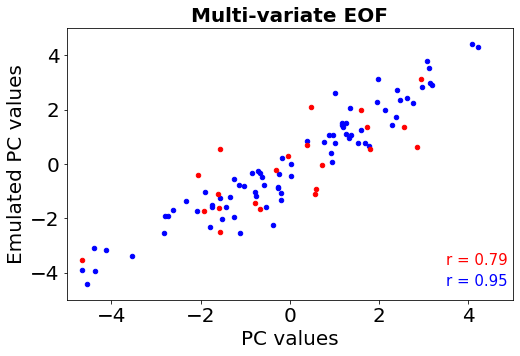

In [25]:
plt.figure(figsize=(8, 5))
    

ax = plt.gca()
#ax2 = ax.twinx()

#df_train.plot(kind='scatter', x='test', y='ej', color = 'black', alpha=1, ax=ax)
df_train.plot(kind='scatter', x='y_train', y='pred', color = 'blue', alpha=1, ax=ax)
df_OS.plot(kind='scatter', x='y_test', y='y_pred', color = 'red', alpha=1, ax=ax)
ax.text(3.5,-4.5, 'r = 0.95', color = 'blue', fontsize=15)
ax.text(3.5,-3.7,'r = 0.79', color = 'red', fontsize=15)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('PC values', size = 20)
ax.set_ylabel('Emulated PC values', size = 20)
ax.set_title('Multi-variate EOF', fontsize=20, 
             fontweight = 'bold')
#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

# Save la figure .................
figname = 'emulator_skill_EOF1_multi-variate.png'
plt.savefig("/data/home/globc/peatier/figures/"+figname, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Prediction de 100 000 points

In [26]:
def MultiLinReg_pred(LHS, X ,y, param_names) :

    LHS_df = pd.DataFrame(LHS)

    lhs = LHS_df.values
    #LHS_df

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    N=len(LHS_df.values)
    tmp = [0]*N
    y_pred = [0]*N
    i=0
    Ycpt=0
    while i<N:
        
        tmp[i] = Coeffs.values*LHS_df.iloc[i]
        y_pred[i] = tmp[i].sum()+R
        i+=1

    #y_pred
    #members = arange(102,100102,1)
    #DFYpred = pd.DataFrame([y_pred, members], index=["y_pred", "members"]).transpose()
    return y_pred

In [27]:
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

pc = {}
for i in range(0,5, 1) :
    EOF_nb = i+1
    y = pc_multi[:,i]
    pc['pc'+str(EOF_nb)] = MultiLinReg_pred(LHS, X ,y, param_names)

In [29]:
df_pc_multi = pd.DataFrame(pc)
hue = ['Emulated members']*len(df_pc_multi)
#df_pc_multi['Legend'] = hue
U_obs_multi_dict = {'pc1' : float(U_obs_multi[0]), 'pc2' : float(U_obs_multi[1]),'pc3' : float(U_obs_multi[2]),'pc4' : float(U_obs_multi[3]),'pc5' : float(U_obs_multi[4])}
df_pc_multi = df_pc_multi.append(U_obs_multi_dict, ignore_index=True)
df_pc_multi

,pc1,pc2,pc3,pc4,pc5
0,1.780764,1.160987,0.178360,0.257798,0.963431
1,1.958757,1.928710,-0.252674,2.728717,0.690692
2,-0.513111,-1.615790,0.219469,-0.917624,-1.475661
3,-0.528796,-0.081274,2.515726,-0.085407,0.326419
4,-0.181189,2.548021,-1.303523,-0.495930,2.531455
...,...,...,...,...,...
99996,-0.239487,-2.710770,0.063331,2.119142,0.995861
99997,0.936955,0.852268,1.420371,-0.478404,-2.047254
99998,4.424868,-1.273558,3.189935,1.526909,0.003104
99999,-0.093171,0.094794,2.206592,0.935712,0.798845


# $5\%$ best models selection

In [30]:
def Error_rj(pc, U_obs):
    rj_list = []
    for i in range(0,len(U_obs),1) :
        j=i+1
        diff = (pc[i]-U_obs[i])**2
        rj_list.append(diff)
    rj_E = sqrt(sum(rj_list)/(len(U_obs)))
    return rj_E

In [31]:
U_obs = df_pc_multi.iloc[100000].to_list()[0:5]
error = []
for i in range(0, len(df_pc_multi), 1) : 
    pc = df_pc_multi.iloc[i].to_list()[0:5] 
    E = Error_rj(pc, U_obs)
    error.append(E)
#error

In [32]:
df_pc_multi['Error'] = error
df_pc_multi

,pc1,pc2,pc3,pc4,pc5,Error
0,1.780764,1.160987,0.178360,0.257798,0.963431,1.793390
1,1.958757,1.928710,-0.252674,2.728717,0.690692,2.336074
2,-0.513111,-1.615790,0.219469,-0.917624,-1.475661,2.239606
3,-0.528796,-0.081274,2.515726,-0.085407,0.326419,2.842302
4,-0.181189,2.548021,-1.303523,-0.495930,2.531455,2.779784
...,...,...,...,...,...,...
99996,-0.239487,-2.710770,0.063331,2.119142,0.995861,2.876353
99997,0.936955,0.852268,1.420371,-0.478404,-2.047254,1.992618
99998,4.424868,-1.273558,3.189935,1.526909,0.003104,2.579094
99999,-0.093171,0.094794,2.206592,0.935712,0.798845,2.787419


In [33]:
df_pc_multi_sort = df_pc_multi.sort_values(by=['Error'], ascending=False)
hue = ['Emulated members']*95000+['$5\%$ best performing models']*5000+['Observations']
df_pc_multi_sort['Legend'] = hue
df_pc_multi_sort

,pc1,pc2,pc3,pc4,pc5,Error,Legend
47543,-8.594732,1.136118,1.236568,-2.218068,1.419427,5.907461,Emulated members
49329,-8.664028,1.127711,1.100957,-2.554236,0.694099,5.881262,Emulated members
21458,-8.815299,1.347583,0.768556,-0.056189,0.276384,5.868872,Emulated members
53579,-8.670904,2.765991,-0.767394,0.170794,-2.524412,5.811034,Emulated members
7744,-8.417936,2.917041,1.227308,-0.338813,-1.234391,5.810555,Emulated members
...,...,...,...,...,...,...,...
719,3.410706,0.114682,-1.866366,-1.398952,-1.121541,0.331354,$5\%$ best performing models
36446,4.229195,0.364321,-1.776244,-1.014316,-1.196124,0.278937,$5\%$ best performing models
62148,3.491597,-0.177597,-2.041750,-1.023634,-1.005551,0.276520,$5\%$ best performing models
27784,3.755031,-0.374120,-2.103675,-0.774908,-1.175476,0.246883,$5\%$ best performing models


# Selection of diverse model candidates (pair-wise distance maximisation)

In [38]:
def compute_distance(df, index_list) :
    distance = {}
    for index in index_list : 
        #print(index)
        point_index = df.loc[index]
        df_short = df.drop([index])
        points = df_short[:]
        diff = {}
        for i in range(1, 6, 1) :
            tmp = (points['pc'+str(i)] - point_index['pc'+str(i)])**2
            diff['EOF '+str(i)+' dist'] = tmp
        distance[index] = sqrt(diff['EOF 1 dist']+diff['EOF 2 dist']+diff['EOF 3 dist']+diff['EOF 4 dist']+diff['EOF 5 dist'])/5
    return distance

In [39]:
import random

def chose_drop_index(distance, limit_remove) :
    distance_df = pd.DataFrame(distance)
    test = pd.DataFrame(distance_df.min()).sort_values(by=0, ascending=True)
    test2 =  pd.DataFrame(test)
    index_drop = []
    for cpt in range(0,limit_remove,2) :
        index1 = test2.index.values.astype(int)[cpt]
        index2 = test2.index.values.astype(int)[cpt+1]
        #print(index1, index2)
        tmp = random.choice([index1, index2])
        index_drop.append(tmp)
    return index_drop

In [40]:
df_best_pc = df_pc_multi_sort[95000:100000].reset_index().drop('index', axis=1)
df_best_pc

,pc1,pc2,pc3,pc4,pc5,Error,Legend
0,4.561026,-1.179649,0.455906,-2.521344,-0.245439,1.409242,$5\%$ best performing models
1,1.311536,0.246642,-1.917188,0.531502,-0.278446,1.408984,$5\%$ best performing models
2,1.431548,0.034227,-1.070969,-0.164737,0.412245,1.408863,$5\%$ best performing models
3,1.645928,-0.752004,-0.987167,-2.595179,-0.174547,1.408785,$5\%$ best performing models
4,2.664154,-0.643110,-0.819833,0.034878,1.224669,1.408693,$5\%$ best performing models
...,...,...,...,...,...,...,...
4995,3.202125,-0.252640,-1.658484,-1.197740,-1.071475,0.345335,$5\%$ best performing models
4996,3.410706,0.114682,-1.866366,-1.398952,-1.121541,0.331354,$5\%$ best performing models
4997,4.229195,0.364321,-1.776244,-1.014316,-1.196124,0.278937,$5\%$ best performing models
4998,3.491597,-0.177597,-2.041750,-1.023634,-1.005551,0.276520,$5\%$ best performing models


In [51]:
df_selection = df_best_pc
index_list = list(range(0, len(df_selection), 1))
n = len(df_selection)
limit_remove = 1000

while n > limit_remove :
    distance = compute_distance(df_selection, index_list)
    #print(distance)
    index_drop = chose_drop_index(distance, limit_remove)
    
    for index in index_drop : 
        index_list.remove(index)
        df_selection = df_selection.drop([index])
    #print(df)
    n = len(df_selection)
    print(n)
df_selection

4500
4000
3500
3000
2500
2000
1500
1000


,pc1,pc2,pc3,pc4,pc5,Error,Legend
0,4.561026,-1.179649,0.455906,-2.521344,-0.245439,1.409242,$5\%$ best performing models
14,3.457860,-1.679393,-1.008767,1.222577,0.149854,1.408000,$5\%$ best performing models
21,2.324627,0.880002,-1.251586,0.132528,0.963719,1.407897,$5\%$ best performing models
22,2.331337,-0.645212,0.705323,-0.183720,-0.328276,1.407851,$5\%$ best performing models
23,4.721325,-0.119299,0.942729,0.408973,-2.013639,1.407797,$5\%$ best performing models
...,...,...,...,...,...,...,...
4989,4.634559,0.145193,-1.809985,-1.474733,-1.103886,0.451973,$5\%$ best performing models
4991,3.348216,0.676575,-1.599191,-1.172401,-1.216721,0.437705,$5\%$ best performing models
4992,3.371017,-0.503399,-1.244955,-1.415064,-1.182972,0.412311,$5\%$ best performing models
4994,3.129125,-0.467833,-1.654585,-0.684276,-1.293146,0.382430,$5\%$ best performing models


In [52]:
limit_remove = 5
while n > (limit_remove+2) :
    distance = compute_distance(df_selection, index_list)
    #print(distance)
    index_drop = chose_drop_index(distance, limit_remove)
    df_selection = df_selection.drop(index_drop)
    for index in index_drop : 
        index_list.remove(index)
    #print(df)
    n = len(df_selection)
    print(n)
df_selection

997
994
991
988
985
982
979
976
973
970
967
964
961
958
955
952
949
946
943
940
937
934
931
928
925
922
919
916
913
910
907
904
901
898
895
892
889
886
883
880
877
874
871
868
865
862
859
856
853
850
847
844
841
838
835
832
829
826
823
820
817
814
811
808
805
802
799
796
793
790
787
784
781
778
775
772
769
766
763
760
757
754
751
748
745
742
739
736
733
730
727
724
721
718
715
712
709
706
703
700
697
694
691
688
685
682
679
676
673
670
667
664
661
658
655
652
649
646
643
640
637
634
631
628
625
622
619
616
613
610
607
604
601
598
595
592
589
586
583
580
577
574
571
568
565
562
559
556
553
550
547
544
541
538
535
532
529
526
523
520
517
514
511
508
505
502
499
496
493
490
487
484
481
478
475
472
469
466
463
460
457
454
451
448
445
442
439
436
433
430
427
424
421
418
415
412
409
406
403
400
397
394
391
388
385
382
379
376
373
370
367
364
361
358
355
352
349
346
343
340
337
334
331
328
325
322
319
316
313
310
307
304
301
298
295
292
289
286
283
280
277
274
271
268
265
262
259
256
253
250


,pc1,pc2,pc3,pc4,pc5,Error,Legend
26,5.239952,-1.393970,-2.066026,1.561935,-1.347515,1.407559,$5\%$ best performing models
177,3.774745,-1.813222,0.703795,-0.630955,-2.358580,1.398628,$5\%$ best performing models
185,2.757151,-1.064444,-1.659669,-1.485144,1.377967,1.397930,$5\%$ best performing models
262,3.192667,0.675475,-0.359390,1.341309,-0.017092,1.392752,$5\%$ best performing models
720,3.691217,1.402264,-2.550010,-0.906327,1.171618,1.364066,$5\%$ best performing models
1418,1.962702,-0.936818,-2.747525,0.760734,-1.978640,1.319704,$5\%$ best performing models
3900,3.353196,1.343925,-1.152051,-0.958497,-2.995949,1.042413,$5\%$ best performing models


In [60]:
df = df_selection
n = len(df)
limit_remove = 1
while n > 5 :
    distance = compute_distance(df, index_list)
    #print(distance)
    index_drop = chose_drop_index(distance, limit_remove)
    df = df.drop(index_drop)
    for index in index_drop : 
        index_list.remove(index)
    #print(df)
    n = len(df)
    print(n)
df

6
5


,pc1,pc2,pc3,pc4,pc5,Error,Legend
26,5.239952,-1.393970,-2.066026,1.561935,-1.347515,1.407559,Candidate 1
177,3.774745,-1.813222,0.703795,-0.630955,-2.358580,1.398628,Candidate 2
720,3.691217,1.402264,-2.550010,-0.906327,1.171618,1.364066,Candidate 5
1418,1.962702,-0.936818,-2.747525,0.760734,-1.978640,1.319704,Candidate 6
3900,3.353196,1.343925,-1.152051,-0.958497,-2.995949,1.042413,Candidate 7


In [61]:
for i in range(0, len(df), 1) : 
    df['Legend'].iloc[i] = 'Candidate '+str(i+1)
df

,pc1,pc2,pc3,pc4,pc5,Error,Legend
26,5.239952,-1.393970,-2.066026,1.561935,-1.347515,1.407559,Candidate 1
177,3.774745,-1.813222,0.703795,-0.630955,-2.358580,1.398628,Candidate 2
720,3.691217,1.402264,-2.550010,-0.906327,1.171618,1.364066,Candidate 3
1418,1.962702,-0.936818,-2.747525,0.760734,-1.978640,1.319704,Candidate 4
3900,3.353196,1.343925,-1.152051,-0.958497,-2.995949,1.042413,Candidate 5


In [62]:
df_fig = df_pc_multi_sort.append(df)
df_fig

,pc1,pc2,pc3,pc4,pc5,Error,Legend
47543,-8.594732,1.136118,1.236568,-2.218068,1.419427,5.907461,Emulated members
49329,-8.664028,1.127711,1.100957,-2.554236,0.694099,5.881262,Emulated members
21458,-8.815299,1.347583,0.768556,-0.056189,0.276384,5.868872,Emulated members
53579,-8.670904,2.765991,-0.767394,0.170794,-2.524412,5.811034,Emulated members
7744,-8.417936,2.917041,1.227308,-0.338813,-1.234391,5.810555,Emulated members
...,...,...,...,...,...,...,...
26,5.239952,-1.393970,-2.066026,1.561935,-1.347515,1.407559,Candidate 1
177,3.774745,-1.813222,0.703795,-0.630955,-2.358580,1.398628,Candidate 2
720,3.691217,1.402264,-2.550010,-0.906327,1.171618,1.364066,Candidate 3
1418,1.962702,-0.936818,-2.747525,0.760734,-1.978640,1.319704,Candidate 4


# Figure

<Figure size 1080x1080 with 0 Axes>

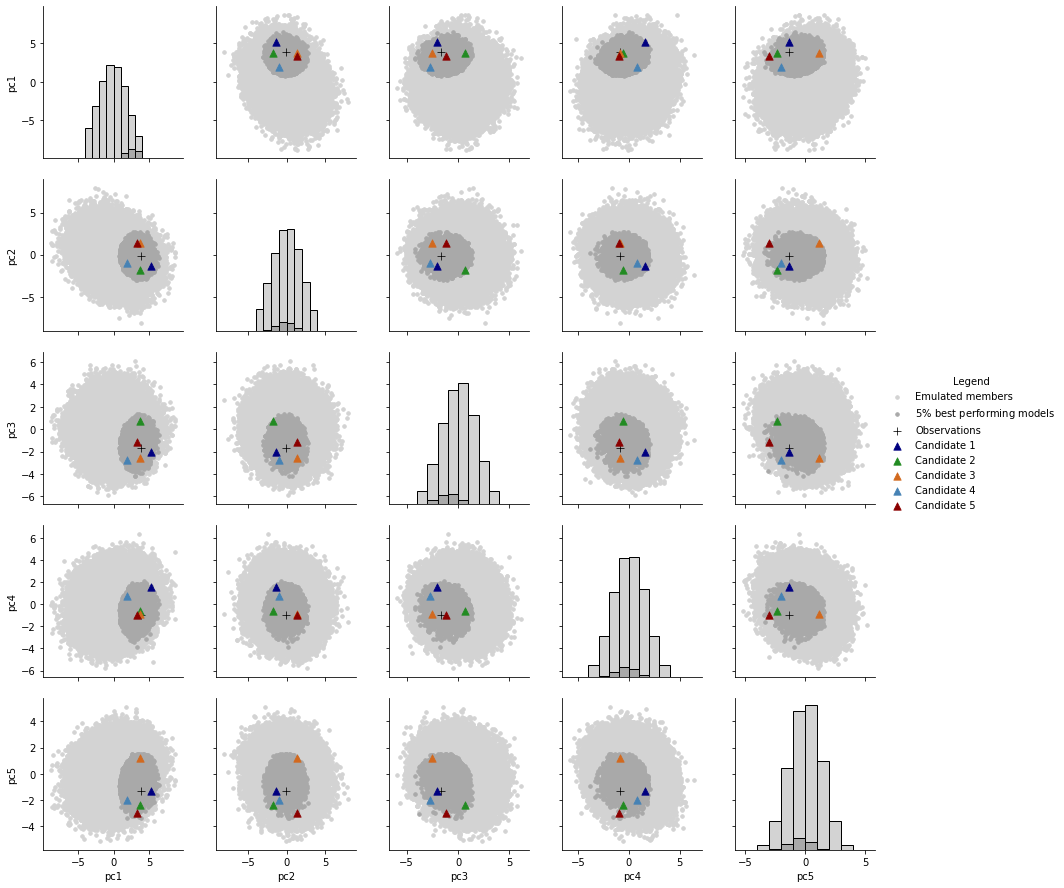

In [64]:
plt.figure(figsize=(15, 15))
    
variables = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5']
p = ['lightgray', 'darkgray','black','navy', 'forestgreen', 'chocolate', 'steelblue', 'darkred', 'purple', 'goldenrod']
m = ['.','.', '+', '^', '^', '^', '^', '^']
n = [-4,-3,-2,-1,0,1,2,3,4]
sns.pairplot(df_fig, vars=variables, hue="Legend", diag_kind='hist', 
             palette=p, 
             markers=m,
             plot_kws=dict(edgecolor=None, s=55), 
             diag_kws=dict(edgecolor='black', bins=n))

# Save figure ---------------
name_fig='Fig5_total.png'
plt.savefig("/data/home/globc/peatier/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
#----------------------------



plt.show()